In [1]:
from load_ag_news import load_ag_news
from load_conll2000 import load_conll2000
import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt

### Question 1

In [2]:
train_set, test_set = load_ag_news('')

In [3]:
id_occ = {}

for data in train_set:
    if data[0] not in id_occ.keys():
        id_occ[data[0]] = 0
    id_occ[data[0]] += 1
    
for key in id_occ.keys():
    id_occ[key] = id_occ[key] / len(train_set)

In [4]:
print(id_occ)

{2: 0.25, 3: 0.25, 1: 0.25, 0: 0.25}


In [5]:
word_occ = dict.fromkeys(id_occ.keys())
for key in word_occ.keys():
    word_occ[key] = {}
id_word = dict.fromkeys(id_occ.keys(), 0)

for data in train_set:
    id_word[data[0]] += len(data[1])
    for word in data[1]:
        if word not in word_occ[data[0]].keys():
            word_occ[data[0]][word] = 0
        word_occ[data[0]][word] += 1

In [6]:
for key_nb in word_occ.keys():
    for key_word, value_word in word_occ[key_nb].items():
        word_occ[key_nb][key_word] = value_word / id_word[key_nb]

In [7]:
print(word_occ[1]['London'])

0.00018036294574312617


In [8]:
def naive_bayes(id_occ, word_occ, input_words, epsilon):
    naive_bayes_proba = id_occ.copy()
    for word in input_words:
        for id_key in id_occ.keys():
            naive_bayes_proba[id_key] *= word_occ[id_key].get(word, 0) + epsilon
    sum_proba = sum(naive_bayes_proba.values())
    for key, value in naive_bayes_proba.items():
        naive_bayes_proba[key] = value / sum_proba
    return naive_bayes_proba

In [9]:
print(naive_bayes(id_occ=id_occ, word_occ=word_occ, input_words=["Arsenal", "is", "a", "londonian", "team", "."], epsilon=10 ** (-5))[1])

0.9924989725858532


In [10]:
def highest_naive_bayes(id_occ, word_occ, input_words, epsilon):
    naive_bayes_proba = id_occ.copy()
    for key, item in naive_bayes_proba.items():
        naive_bayes_proba[key] = np.log(item)
    for word in input_words:
        for id_key in id_occ.keys():
            naive_bayes_proba[id_key] += np.log(word_occ[id_key].get(word, 0) + epsilon)
    return max(naive_bayes_proba, key=naive_bayes_proba.get)

In [11]:
pred_corpus_esmall = []
pred_corpus_emedium = []
pred_corpus_ehigh = []

for data_test in test_set:
    pred_corpus_esmall.append(data_test[0] == highest_naive_bayes(id_occ=id_occ, word_occ=word_occ, input_words=data_test[1], epsilon=10**(-10)))
    pred_corpus_emedium.append(data_test[0] == highest_naive_bayes(id_occ=id_occ, word_occ=word_occ, input_words=data_test[1], epsilon=10**(-5)))
    pred_corpus_ehigh.append(data_test[0] == highest_naive_bayes(id_occ=id_occ, word_occ=word_occ, input_words=data_test[1], epsilon=1))

print(f'Pour espsilon = 10**(-10), le taux de prédiction est de : {sum(pred_corpus_esmall) / len(pred_corpus_esmall)}')
print(f'Pour espsilon = 10**(-5), le taux de prédiction est de : {sum(pred_corpus_emedium) / len(pred_corpus_emedium)}')
print(f'Pour espsilon = 1, le taux de prédiction est de : {sum(pred_corpus_ehigh) / len(pred_corpus_ehigh)}')

Pour espsilon = 10**(-10), le taux de prédiction est de : 0.9010526315789473
Pour espsilon = 10**(-5), le taux de prédiction est de : 0.8940789473684211
Pour espsilon = 1, le taux de prédiction est de : 0.4909210526315789


### Question 2

In [12]:
train_set, test_set = load_conll2000('')

In [13]:
nb_words = 0
word_prob = {}

for sentence in train_set:
    for word in sentence:
        if word[0] not in word_prob.keys():
            word_prob[word[0]] = 0
        word_prob[word[0]] += 1
        nb_words +=1

for key, value in word_prob.items():
    word_prob[key] = value / nb_words

In [14]:
word_a = dict.fromkeys(word_prob.keys())
for key in word_a.keys():
    word_a[key] = {}

for sentence in train_set:
    if len(sentence) <= 1:
        continue
    for i in range(len(sentence) - 1):
        if sentence[i+1][0] not in word_a[sentence[i][0]].keys():
            word_a[sentence[i][0]][sentence[i+1][0]] = 0
        word_a[sentence[i][0]][sentence[i+1][0]] += 1


for key, value in word_a.items():
    sum_values = sum(value.values())
    for key_next, value_next in value.items():
        word_a[key][key_next] = value_next / sum_values

word_a['NUM']['NOUN']

0.34821321140656963

In [15]:
word_b = dict.fromkeys(word_prob.keys())
for key in word_b.keys():
    word_b[key] = {}
    
for sentence in train_set:
    for word in sentence:
        if word[1] not in word_b[word[0]].keys():
            word_b[word[0]][word[1]] = 0
        word_b[word[0]][word[1]] += 1

for key, value in word_b.items():
    sum_values = sum(value.values())
    for key_next, value_next in value.items():
        word_b[key][key_next] = value_next / sum_values

word_b['PUNCT']['.']

0.36019485612847296

In [16]:
def get_alpha(word_prob, word_a, word_b, sentence, epsilon, labels):
    arr_alpha = [np.array([word_prob[key] * (word_b[key].get(sentence[0], 0) + epsilon) for key in labels])]
    arr_alpha[-1] = arr_alpha[-1] / np.sum(arr_alpha[-1])
    for word in np.array(sentence)[1:]:
        new_alpha = []
        for key in labels:
            list_a = np.array([word_a[key_a].get(key, 0) for key_a in labels])
            elem_alpha = (word_b[key].get(word, 0) + epsilon) * np.sum(arr_alpha[-1] * list_a)
            new_alpha.append(elem_alpha)
        arr_new_alpha = np.array(new_alpha)
        arr_new_alpha = arr_new_alpha / np.sum(arr_new_alpha)
        arr_alpha.append(arr_new_alpha)
    return np.array(arr_alpha)

In [17]:
def get_beta(word_prob, word_a, word_b, sentence, epsilon, labels):
    arr_beta = [np.ones(len(word_prob))]
    arr_beta[-1] = arr_beta[-1] / np.sum(arr_beta[-1])
    for word in np.flip(sentence)[1:]:
        new_beta = []
        list_b = np.array([(word_b[key_b].get(word, 0) + epsilon) for key_b in labels])
        for key in labels:
            list_a = np.array([word_a[key].get(key_a, 0) for key_a in labels])
            elem_beta = np.sum(arr_beta[-1] * list_a * list_b)
            new_beta.append(elem_beta)
        arr_new_beta = np.array(new_beta)
        arr_new_beta = arr_new_beta / np.sum(arr_new_beta)
        arr_beta.append(arr_new_beta)
    return np.flip(arr_beta, axis=0)

In [18]:
def get_forward_backward(word_prob, word_a, word_b, sentence, epsilon, labels):
    alpha = get_alpha(word_prob=word_prob, word_a=word_a, word_b=word_b, sentence=sentence, epsilon=epsilon, labels=labels)
    beta = get_beta(word_prob=word_prob, word_a=word_a, word_b=word_b, sentence=sentence, epsilon=epsilon, labels=labels)
    forward_backward = alpha * beta
    forward_backward = forward_backward / (forward_backward.sum(axis=1)).reshape(-1, 1)
    return forward_backward

In [19]:
def get_predict_labels(word_prob, word_a, word_b, sentence, epsilon):
    labels = list(word_prob.keys())
    forward_backward = get_forward_backward(word_prob=word_prob, word_a=word_a, word_b=word_b, sentence=sentence, epsilon=epsilon, labels=labels)
    return [labels[ind] for ind in np.argmax(forward_backward, axis=1)]

In [20]:
simple_sentence = ["I", "am", "a", "student", "in", "a", "French", "school", "."] 
get_predict_labels(word_prob=word_prob, word_a=word_a, word_b=word_b, sentence=simple_sentence, epsilon=1e-5)

['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']

In [21]:
def get_score_predict(word_prob, word_a, word_b, text, epsilon):
    total_predict = 0
    total_correct_predict = 0
    for label_sentence in text:
        sentence = [x[1] for x in label_sentence]
        total_predict += len(sentence)
        predict_labels = get_predict_labels(word_prob=word_prob, word_a=word_a, word_b=word_b, sentence=sentence, epsilon=epsilon)
        for ind, label in enumerate(predict_labels):
            if label == label_sentence[ind][0]:
                total_correct_predict += 1
    
    return total_correct_predict / total_predict

In [22]:
score_predict = get_score_predict(word_prob=word_prob, word_a=word_a, word_b=word_b, text=test_set, epsilon=1e-5)
print(f'Le score prédit en pourcentage est de {score_predict * 100} %')

Le score prédit en pourcentage est de 92.69265677438419 %


### Question 3

In [23]:
X = np.loadtxt("signal_X.txt")
Y = np.loadtxt("signal_Y.txt")

In [24]:
def get_param_kalman(Y):
    cov1 = np.sum(Y[:-1] * Y[1:]) / (len(Y) - 1)
    cov2 = np.sum(Y[:-2] * Y[2:]) / (len(Y) - 2)
    
    a = cov2 / cov1
    b = np.sqrt(cov1 / a)
    
    return a, b, 

In [25]:
a, b = get_param_kalman(Y)
print(f'Les paramètres de Kalman sont a : {a} et b : {b}')

Les paramètres de Kalman sont a : 0.5966338342965285 et b : 0.8860784695470194


In [26]:
def get_kalman(Y, a, b):
    X_pred = [b * Y[0]]
    sig = [1 - b**2]
    
    for ind in np.arange(1, np.size(Y), 1):
        x_cond = a * X_pred[-1]
        sig_cond = 1 - a**2 + (a**2) * sig[-1]
        
        y_tild = Y[ind] - b * x_cond
        s_next = (b**2) * sig_cond + 1 - (b**2)
        k_next = sig_cond * b / s_next
        
        x_next = x_cond + k_next * y_tild
        sig_next = (1 - b * k_next) * sig_cond
        
        X_pred.append(x_next)
        sig.append(sig_next)
    
    return np.array(X_pred)

In [27]:
def get_mse(arr1, arr2):
    return np.sum((arr1 - arr2) ** 2) / np.size(arr1)

In [28]:
X_pred = get_kalman(Y=Y, a=a, b=b)
print(f'L\'erreur quadratique moyenne entre X et X_pred est de {get_mse(arr1=X, arr2=X_pred)}')
print(f'L\'erreur quadratique moyenne entre X et Y est de {get_mse(arr1=X, arr2=Y)}')
print(f'Le filtre de Kalman permet donc d\'obtenir de meilleurs performances avec une erreur quadratique moyenne moindre')

L'erreur quadratique moyenne entre X et X_pred est de 0.1744952107401793
L'erreur quadratique moyenne entre X et Y est de 0.20225719834189368
Le filtre de Kalman permet donc d'obtenir de meilleurs performances avec une erreur quadratique moyenne moindre


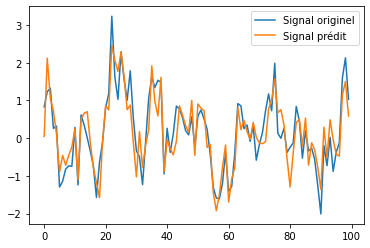

In [29]:
plt.figure(1)
plt.plot(X[:100], label='Signal originel')
plt.plot(X_pred[:100], label='Signal prédit')
plt.legend(loc='upper right')
plt.show()